In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1
import glob

matlab_lines = np.array([[0,0.447,0.741],[0.85,0.325,0.098],[0.929,0.694,0.125],[0.494,0.184,0.556],
                         [0.466,0.674,0.188],[0.301,0.745,0.933],[0.635,0.078,0.184]])

files = np.sort(glob.glob("RDP_results/*.hier_copynum.txt"));

Load RDP files, which relate taxonomy to miTAG sequences obtained via shotgun metagenomics of enrichment experiments. Show table of relative abundances (%) of different taxonomic orders. Sample numbers beginning with '6' were enriched at pH 6.0, and sample numbers beginning in '7' were enriched at pH 7.3

In [3]:
for file in files:
    #load copynumber adjusted RDP output files
    
    #df = pd.read_csv(file,sep="\t",on_bad_lines='skip',skiprows=6,header=None)
    df = pd.read_csv(file,sep="\t",error_bad_lines=False,skiprows=6,header=None)
    df.columns = ['Rank','Name','Abundance']

    total = df.iloc[0].Abundance

    #Remove rows with zero abundance
    df = df.iloc[np.where(df.Abundance > 0.0)[0]]

    #Compute relative abundances
    df['RelativeAbundance'] = df.Abundance/total

    unclassified_root = df.iloc[np.where(df.Name == 'unclassified_Root')[0]]
    unclassified_bacteria = df.iloc[np.where(df.Name == 'unclassified_Bacteria')[0]]
    unclassified_archaea = df.iloc[np.where(df.Name == 'unclassified_Archaea')[0]]
    unclassified_eukaryota = df.iloc[np.where(df.Name == 'unclassified_Eukaryota')[0]]

    #Keep only abundances at the level of order
    df = df.iloc[np.where(df.Rank == 'order')[0]]
    
    #Keep only taxa with abundance greater than 1%. Merge the rest into "Other classified"
    T = 0.01
    other_classified_total = np.sum(df['RelativeAbundance'].iloc[np.where(df.RelativeAbundance < T)[0]].values)
    df = df.iloc[np.where(df.RelativeAbundance >= T)[0]]
    df = pd.concat([unclassified_bacteria,unclassified_archaea,unclassified_eukaryota,unclassified_root,pd.DataFrame(data = {'Name':'Other classified',"RelativeAbundance":[other_classified_total]}),df])

    if file == files[0]:
        ra = df['RelativeAbundance']
        ra.index = df['Name'].values
        ra.name = file[12:14]
    else:
        df_temp = df['RelativeAbundance']
        df_temp.index = df['Name'].values
        df_temp.name = file[12:14]
        ra=pd.concat([ra,df_temp],axis=1)
        
ra = ra.fillna(0)
samp_ids = np.array(ra.columns)

ra = ra*100

ra

,61,62,63,64,65,66,71,72,73,74,75,76
Other classified,0.000000,0.000000,0.011725,0.000000,0.018613,0.000000,0.000000,0.353121,0.456977,0.000000,0.468047,0.000000
Rhizobiales,1.757926,21.893591,0.000000,10.864978,6.433536,2.529946,96.363970,68.175819,26.678846,91.791150,71.139266,90.043776
Pseudomonadales,89.696619,71.995725,90.055595,82.478891,85.929313,67.085517,3.246379,0.000000,68.063921,7.423497,0.000000,9.019087
unclassified_Bacteria,0.000000,0.061353,0.052066,0.022897,0.000000,0.045925,0.000000,0.028969,0.054408,0.085586,0.054617,0.000000
Enterobacterales,0.000000,0.000000,2.321067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Burkholderiales,0.000000,0.000000,0.000000,0.000000,0.000000,24.964417,0.000000,31.356802,0.000000,0.000000,28.070650,0.000000


Plot RDP results.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


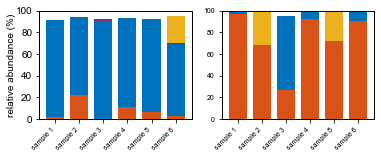

In [8]:
width=0.75
T = 0.01

clr_order = [6,1,0,6,3,2]

fig, axs = plt.subplots(1, 2,figsize=(6, 2))

j = 0
plot_idx = np.array(range(0,6),dtype=int)
ra_sub = ra[samp_ids[plot_idx]]
#Keep only taxa with nonzero abundance.
# ra_sub = ra_sub[ra_sub > T].dropna(how='all').fillna(0)
axs[j].bar(samp_ids[plot_idx], ra_sub.iloc[0], width, label=ra_sub.iloc[0].name)
heights = ra_sub.iloc[0]
for i in range(1,len(ra_sub)):
    axs[j].bar(samp_ids[plot_idx], ra_sub.iloc[i], width, label=ra_sub.iloc[i].name,bottom = heights, color=matlab_lines[clr_order[i],:])
    heights = heights + ra_sub.iloc[i]
# axs[j].set_title('pH = '+str(ph_plot));
#axs[j].set_xticks(range(0,6),['sample 1', 'sample 2','sample 3','sample 4','sample 5','sample 6'],rotation=45,horizontalalignment='right',fontsize=7);
axs[j].set_xticklabels(['sample 1', 'sample 2', 'sample 3', 'sample 4', 'sample 5', 'sample 6'], rotation=45, ha='right', fontsize=7)
axs[j].set_ylim([0,100]);
axs[j].set_ylabel('relative abundance (%)',verticalalignment='center')

j = 1
plot_idx = np.array(range(6,12),dtype=int)
ra_sub = ra[samp_ids[plot_idx]]
#Keep only taxa with nonzero abundance.
# ra_sub = ra_sub[ra_sub > T].dropna(how='all').fillna(0)
axs[j].bar(samp_ids[plot_idx], ra_sub.iloc[0], width, label=ra_sub.iloc[0].name)
heights = ra_sub.iloc[0]
for i in range(1,len(ra_sub)):
    axs[j].bar(samp_ids[plot_idx], ra_sub.iloc[i], width, label=ra_sub.iloc[i].name,bottom = heights, color=matlab_lines[clr_order[i],:])
    heights = heights + ra_sub.iloc[i]
# axs[j].set_title('pH = '+str(ph_plot));
axs[j].set_ylim([0,100]);
#axs[j].set_xticks(range(0,6),['sample 1', 'sample 2','sample 3','sample 4','sample 5','sample 6'],rotation=45,horizontalalignment='right',fontsize=7);
axs[j].set_xticklabels(['sample 1', 'sample 2', 'sample 3', 'sample 4', 'sample 5', 'sample 6'], rotation=45, ha='right', fontsize=7)


#axs[j].set_yticks(ticks=[0,20,40,60,80,100],fontsize=7);
axs[j].set_yticks(ticks=[0, 20, 40, 60, 80, 100])
axs[j].tick_params(axis='y', labelsize=7)
# plt.savefig('Fig2_enrichment_relabund.svg')